<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/template-kit/raw/main/img/DATAIA-h.png" width="90%"></a>
</div>

# Data Camp RAMP Challenge on the avalanche risk prediction

<i> Florent Blanc, Bryan Chen, Sibylle Degos, Alice Devilder, Rémy Grabet, Théo Paquier </i>

## Introduction

Describe the challenge, in particular:

- Where the data comes from?
- What is the task this challenge aims to solve?
- Why does it matter?

### Avalanche risk

Avalanches pose a significant threat to outdoor enthusiasts, ski patrol teams, and mountain communities. Predicting avalanche risk accurately is crucial for ensuring safety in mountainous regions. This challenge aims to leverage data science to analyze and forecast avalanche risk based on historical reports from Météo-France. By processing and interpreting structured data extracted from avalanche risk bulletins, we can improve preparedness and decision-making in avalanche-prone areas.  

### The BERA database, a catalog of avalanche risk bulletins

The data for this challenge comes from **Météo-France** through the **Bulletins d'Estimation du Risque d'Avalanche (BERA)**, which provide official assessments of avalanche hazards. Originally, these reports were only available in PDF format, making them difficult to analyze systematically. However, [multi-coop](https://gitlab.com/multi-coop/meteofrance_bra_hist) has extracted and structured this data into CSV files, categorized by mountain region (massif) and publication date.

The dataset consists of **34,286 records**, each representing a daily avalanche risk bulletin for a specific massif. It includes **47 features**, covering information on:
- **Avalanche risk levels (`risque1`, `risque2`, `risque_maxi`)** at different altitudes.
- **Geographic and temporal data (`massif`, `altitude`, `date`)**.
- **Weather conditions (`isotherme_0`, `precipitation_neige_veille_epaisseur`, `vent_altitude_*`)**.
- **Risk evolution trends (`evolurisque1`, `evolurisque2`)**.

This dataset provides a historical record of avalanche risk conditions, making it a valuable resource for predictive modeling.

### What is the task this challenge aims to solve?  
The main objective of this challenge is to **predict avalanche risk** based on the structured BERA data. By analyzing historical risk reports and meteorological conditions, we can develop models that estimate avalanche hazards more effectively.  

This task has multiple applications. First, it can help outdoor enthusiasts, ski patrols, and mountain rescue teams plan safer routes and make informed decisions before heading into avalanche-prone terrain. Additionally, the challenge aims to serve as an educational tool for analyzing past avalanche incidents, helping researchers and safety experts understand risk factors. Finally, by improving real-time risk estimation models, the challenge contributes to broader efforts in avalanche forecasting and disaster prevention.  

### Why does it matter?  
Avalanches are a deadly natural hazard, posing risks to skiers, snowboarders, mountaineers, and local communities. Developing accurate avalanche prediction models can save lives by providing crucial insights into when and where avalanches are most likely to occur.  

Improved avalanche forecasting enhances safety measures for ski resorts, backcountry travelers, and rescue operations. It also contributes to environmental and climate research, as avalanche behavior is influenced by broader weather patterns and climate change. By transforming unstructured reports into actionable insights, this challenge harnesses the power of data science to improve preparedness and response in mountainous regions.  

# Exploratory data analysis

The goal of this section is to show what's in the data, and how to play with it.
This is the first set in any data science project, and here, you should give a sense of the data the participants will be working with.

You can first load and describe the data, and then show some interesting properties of it.

In [1]:
%%capture
!pip install ramp-workflow

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [3]:
import geopandas as gpd
import os as os
from urllib.request import urlretrieve
from zipfile import ZipFile
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import CircleMarker

### Get access to the training data

In [4]:
import problem
X_df, y = problem.get_train_data()

In [5]:
data = pd.concat([X_df,y],axis=1)

## The static features

**TODO** <span style="color:red">Red variables</span> are ids, labels, or other human-annotated features, so they should not be used as input in the classification. <span style="color:lightblue">Light blue variables</span> are legal but not likely to contribute information to the classification. Black variables are definitely discriminative.

- **Avalanche Risk Levels**: 
  - `risque1`: Estimated risk level for all altitudes or the lowest ones.
  - `risque2`: Estimated risk level for the highest altitudes.
  - `risque_maxi`: The highest risk level reported for a given massif.
- **Geographic and Temporal Information**:
  - `date`: The publication date of the bulletin.
  - `massif`: The mountain region for which the risk is assessed.
  - `altitude`: Altitude information, if available.
- **Meteorological Conditions**:
  - `isotherme_0`: Altitude of the 0°C isotherm.
  - `isotherme_moins_10`: Altitude of the -10°C isotherm.
  - `precipitation_neige_veille_epaisseur`: Snowfall height measured the day before.
  - `vitesse_vent_altitude_1`: Wind speed at a lower altitude.
  - `vitesse_vent_altitude_2`: Wind speed at a higher altitude.
  - `direction_vent_altitude_1`: Wind direction at a lower altitude.
  - `direction_vent_altitude_2`: Wind direction at a higher altitude.
  - `limite_pluie_neige`: Rain-snow limit altitude.
- **Risk Evolution and Additional Context**:
  - `evolurisque1`, `evolurisque2`: Evolution of risk levels over time.
  - `commentaire`: Additional commentary on risk conditions.
  - `url_telechargement`: Link to the original BERA report in PDF format. 

In [6]:
X_df.head()

,date,massif,evolurisque1,altitude,risque2,risque_maxi,00_temps,00_mer_de_nuages,00_limite_pluie_neige,00_isotherme_0,00_isotherme_moins_10,00_altitude_vent_1,00_altitude_vent_2,00_direction_vent_altitude_1,00_vitesse_vent_altitude_1,00_direction_vent_altitude_2,00_vitesse_vent_altitude_2,06_temps,06_mer_de_nuages,06_limite_pluie_neige,06_isotherme_0,06_isotherme_moins_10,06_altitude_vent_1,06_altitude_vent_2,06_direction_vent_altitude_1,06_vitesse_vent_altitude_1,06_direction_vent_altitude_2,06_vitesse_vent_altitude_2,12_temps,12_mer_de_nuages,12_limite_pluie_neige,12_isotherme_0,12_isotherme_moins_10,12_altitude_vent_1,12_altitude_vent_2,12_direction_vent_altitude_1,12_vitesse_vent_altitude_1,12_direction_vent_altitude_2,12_vitesse_vent_altitude_2,precipitation_neige_veille_altitude,precipitation_neige_veille_epaisseur
0,2020-01-21,HAUT-VAR_HAUT-VERDON,NaN,NaN,2.0,2,Très nuageux,Non,Sans objet,1200,3600,3000,Sans objet,SE,60,Sans objet,Sans objet,Eclaircies,Non,Sans objet,1400,3800,3000,Sans objet,E,60,Sans objet,Sans objet,Variable,Non,Sans objet,1900,3900,3000,Sans objet,E,50,Sans objet,Sans objet,1800,0
1,2019-02-11,CINTO-ROTONDO,NaN,1800.0,2.0,2,Peu nuageux,Non,Sans objet,1600,4300,1500,3000,W,40,W,100,Averses de neige,Non,700,1000,2600,1500,3000,W,40,W,110,Averses de neige,Non,900,1200,2400,1500,3000,NW,50,NW,60,1800,0
2,2021-11-19,HAUTE-MAURIENNE,NaN,3000.0,3.0,3,Beau temps,Non,Sans objet,3200,4900,3000,4000,_,0,E,30,Beau temps,Non,Sans objet,3400,4900,3000,4000,NE,10,E,20,Beau temps,Non,Sans objet,3500,5000,3000,4000,_,0,_,0,1800,0
3,2020-01-26,OISANS,NaN,2200.0,2.0,3,Variable,Non,Sans objet,1900,3300,2500,3500,SE,10,SW,20,Neige faible,Non,1200,1600,3300,2500,3500,_,0,SW,20,Neige faible,Non,1300,1600,3300,2500,3500,_,0,W,30,1800,5
4,2021-12-08,VANOISE,NaN,NaN,4.0,4,Neige faible,Non,1200,2200,3700,3000,4000,SW,20,W,40,Neige modérée,Non,800,1000,3500,3000,4000,_,0,SW,40,Neige modérée,Non,400,700,2800,3000,4000,N,20,NW,20,1800,35


In [7]:
# Summary statistics
data.describe()

,evolurisque1,altitude,risque2,risque_maxi,risque1
count,2913.000000,9046.000000,21862.000000,21862.000000,21862.000000
mean,2.348438,2248.960867,2.040847,2.165859,1.641753
std,0.603144,283.113315,0.823429,0.807217,0.761482
min,1.000000,1300.000000,1.000000,1.000000,1.000000
25%,2.000000,2000.000000,1.000000,2.000000,1.000000
50%,2.000000,2200.000000,2.000000,2.000000,1.000000
75%,3.000000,2400.000000,3.000000,3.000000,2.000000
max,5.000000,3600.000000,5.000000,5.000000,5.000000


## The risk levels

The avalanche risk levels are classified into five categories, ranging from low to extreme risk. These levels are defined as follows:

- **Level 1 (Low)**: Low risk of avalanches, natural triggers are unlikely.

- **Level 2 (Moderate)**: Moderate risk of avalanches, natural triggers are possible.

- **Level 3 (Considerable)**: Considerable risk of avalanches, natural triggers are likely.

- **Level 4 (High)**: High risk of avalanches, natural triggers are very likely.

- **Level 5 (Very High)**: Very high risk of avalanches, natural triggers are certain.

The risk levels are reported for different altitudes, with `risque1` and `risque2` representing the risk levels at lower and higher altitudes, respectively. The `risque_maxi` variable indicates the highest risk level reported for a given massif.

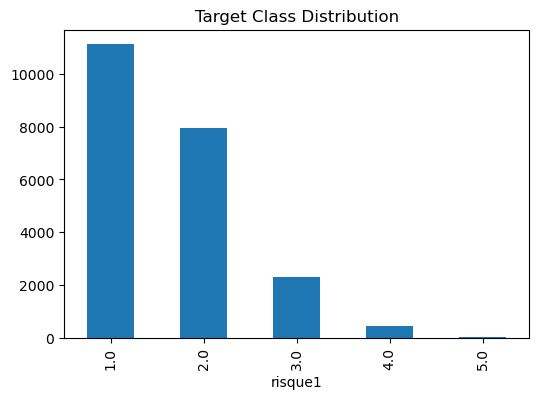

In [8]:
# Class distribution
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar')
plt.title("Target Class Distribution")
plt.show()

Check the number of Nan per column

In [9]:
data.columns

Index(['date', 'massif', 'evolurisque1', 'altitude', 'risque2', 'risque_maxi',
       '00_temps', '00_mer_de_nuages', '00_limite_pluie_neige',
       '00_isotherme_0', '00_isotherme_moins_10', '00_altitude_vent_1',
       '00_altitude_vent_2', '00_direction_vent_altitude_1',
       '00_vitesse_vent_altitude_1', '00_direction_vent_altitude_2',
       '00_vitesse_vent_altitude_2', '06_temps', '06_mer_de_nuages',
       '06_limite_pluie_neige', '06_isotherme_0', '06_isotherme_moins_10',
       '06_altitude_vent_1', '06_altitude_vent_2',
       '06_direction_vent_altitude_1', '06_vitesse_vent_altitude_1',
       '06_direction_vent_altitude_2', '06_vitesse_vent_altitude_2',
       '12_temps', '12_mer_de_nuages', '12_limite_pluie_neige',
       '12_isotherme_0', '12_isotherme_moins_10', '12_altitude_vent_1',
       '12_altitude_vent_2', '12_direction_vent_altitude_1',
       '12_vitesse_vent_altitude_1', '12_direction_vent_altitude_2',
       '12_vitesse_vent_altitude_2', 'precipitation_neig

In [10]:
data.shape

(21862, 42)

In [11]:
print("Missing Values:\n", data.isna().sum())

Missing Values:
 date                                        0
massif                                      0
evolurisque1                            18949
altitude                                12816
risque2                                     0
risque_maxi                                 0
00_temps                                    0
00_mer_de_nuages                            0
00_limite_pluie_neige                       0
00_isotherme_0                              0
00_isotherme_moins_10                       0
00_altitude_vent_1                          0
00_altitude_vent_2                          0
00_direction_vent_altitude_1                0
00_vitesse_vent_altitude_1                  0
00_direction_vent_altitude_2                0
00_vitesse_vent_altitude_2                  0
06_temps                                    0
06_mer_de_nuages                            0
06_limite_pluie_neige                       0
06_isotherme_0                              0
06_isotherme_moin

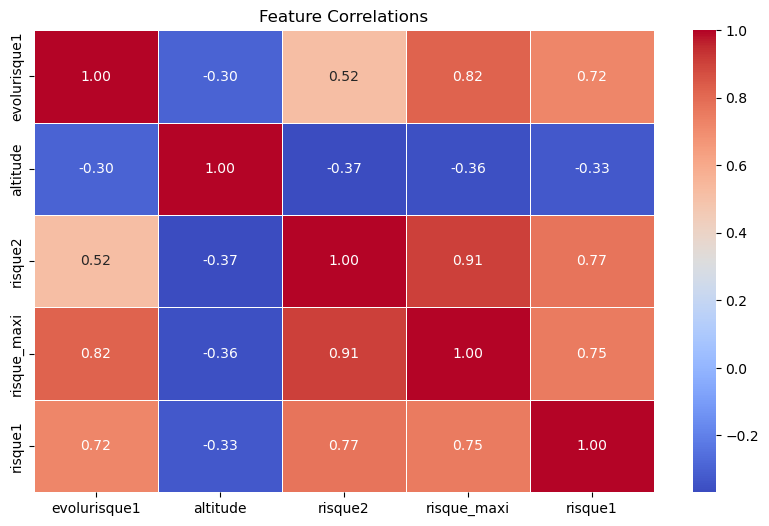

In [12]:
# Select only numerical columns
numeric_data = data.select_dtypes(include=['number'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlations")
plt.show()

Check the mean risk for each massif :

In [13]:
massifs = data['massif'].unique()

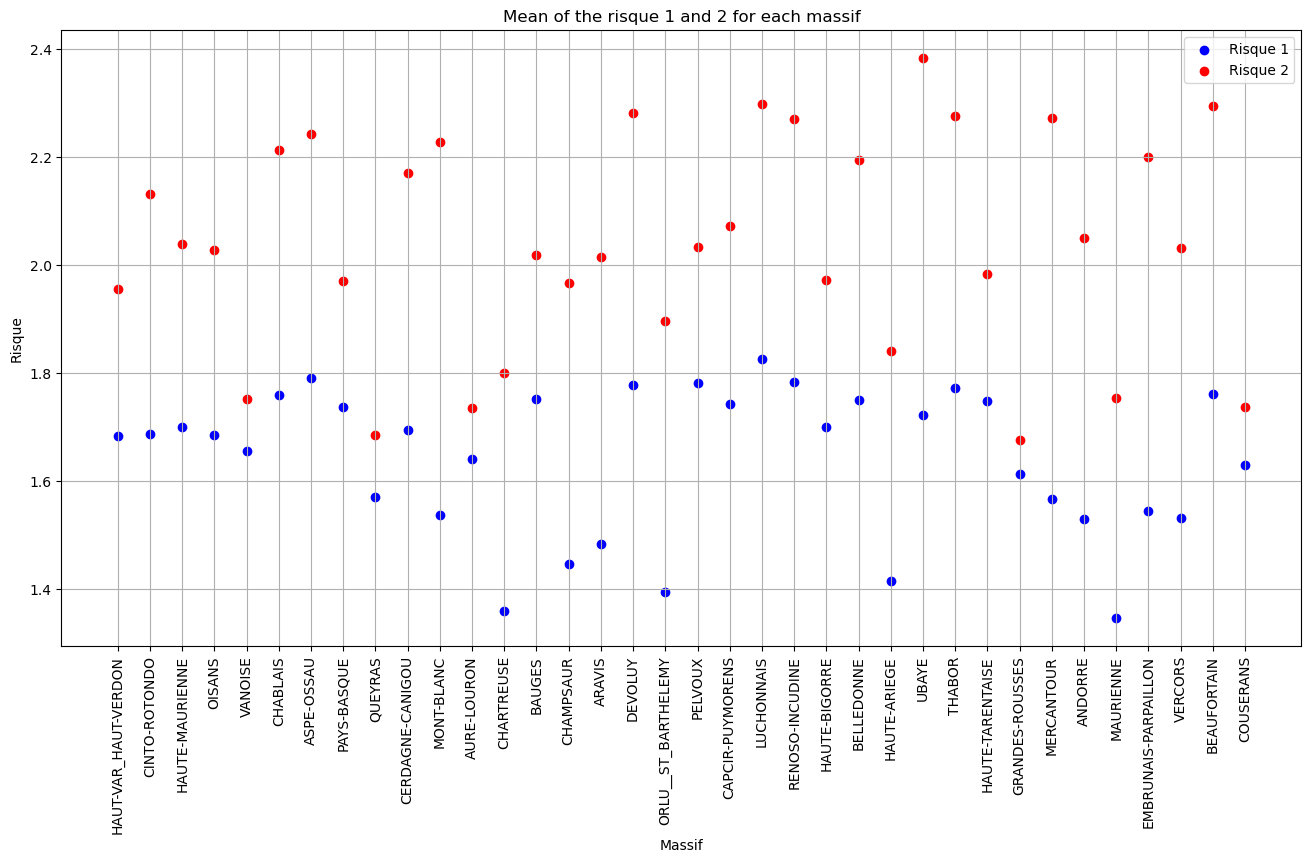

In [14]:
data_massif = data.groupby('massif')

# Plot the mean of the target variable for each massif and the risque 2 variable
plt.figure(figsize=(16,8))
plt.scatter(massifs, data_massif['risque1'].mean(), c='b')
plt.scatter(massifs, data_massif['risque2'].mean(), c='r')
plt.xticks(rotation=90)
plt.xlabel('Massif')
plt.ylabel('Risque')
plt.legend(['Risque 1', 'Risque 2'])
plt.title('Mean of the risque 1 and 2 for each massif')
plt.grid()
plt.show()

### Create a time series plot of the risk levels

In [15]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [16]:
# Check if the date are unique to put them as index
data['date'].nunique() == data.shape[0]

False

The date is not unique so we will have to group by massif and then date to plot the risk levels over time.

In [17]:
df_massifs = {massif: data[data['massif'] == massif] for massif in massifs}

In [18]:
for massif, df in df_massifs.items():
    unique_dates = df['date'].nunique()
    total_rows = df.shape[0]
    
    print(f"Massif: {massif}")
    print(f"Unique dates: {unique_dates}, Total rows: {total_rows}")
    print(f"Are all dates unique? {'Yes' if unique_dates == total_rows else 'No'}\n")


Massif: HAUT-VAR_HAUT-VERDON
Unique dates: 597, Total rows: 597
Are all dates unique? Yes

Massif: CINTO-ROTONDO
Unique dates: 611, Total rows: 611
Are all dates unique? Yes

Massif: HAUTE-MAURIENNE
Unique dates: 606, Total rows: 606
Are all dates unique? Yes

Massif: OISANS
Unique dates: 616, Total rows: 616
Are all dates unique? Yes

Massif: VANOISE
Unique dates: 611, Total rows: 611
Are all dates unique? Yes

Massif: CHABLAIS
Unique dates: 598, Total rows: 598
Are all dates unique? Yes

Massif: ASPE-OSSAU
Unique dates: 607, Total rows: 607
Are all dates unique? Yes

Massif: PAYS-BASQUE
Unique dates: 620, Total rows: 620
Are all dates unique? Yes

Massif: QUEYRAS
Unique dates: 618, Total rows: 618
Are all dates unique? Yes

Massif: CERDAGNE-CANIGOU
Unique dates: 619, Total rows: 619
Are all dates unique? Yes

Massif: MONT-BLANC
Unique dates: 613, Total rows: 613
Are all dates unique? Yes

Massif: AURE-LOURON
Unique dates: 595, Total rows: 595
Are all dates unique? Yes

Massif: CHARTR

In [19]:
data.columns

Index(['date', 'massif', 'evolurisque1', 'altitude', 'risque2', 'risque_maxi',
       '00_temps', '00_mer_de_nuages', '00_limite_pluie_neige',
       '00_isotherme_0', '00_isotherme_moins_10', '00_altitude_vent_1',
       '00_altitude_vent_2', '00_direction_vent_altitude_1',
       '00_vitesse_vent_altitude_1', '00_direction_vent_altitude_2',
       '00_vitesse_vent_altitude_2', '06_temps', '06_mer_de_nuages',
       '06_limite_pluie_neige', '06_isotherme_0', '06_isotherme_moins_10',
       '06_altitude_vent_1', '06_altitude_vent_2',
       '06_direction_vent_altitude_1', '06_vitesse_vent_altitude_1',
       '06_direction_vent_altitude_2', '06_vitesse_vent_altitude_2',
       '12_temps', '12_mer_de_nuages', '12_limite_pluie_neige',
       '12_isotherme_0', '12_isotherme_moins_10', '12_altitude_vent_1',
       '12_altitude_vent_2', '12_direction_vent_altitude_1',
       '12_vitesse_vent_altitude_1', '12_direction_vent_altitude_2',
       '12_vitesse_vent_altitude_2', 'precipitation_neig

In [20]:
list_massifs = list(data['massif'].unique())

In [21]:
df_ordered = data[data['massif'] == 'HAUT-VAR_HAUT-VERDON'].sort_values(by='date')

In [22]:
list_massifs.remove('HAUT-VAR_HAUT-VERDON')

In [23]:
for massif in list_massifs:
    df_ordered = pd.concat([df_ordered,data[data['massif']==massif].sort_values(by='date')],axis=0)

In [24]:
core_vars = [
    "temps", "mer_de_nuages", "limite_pluie_neige", "isotherme_0",
    "isotherme_moins_10", "altitude_vent_1", "altitude_vent_2",
    "direction_vent_altitude_1", "vitesse_vent_altitude_1",
    "direction_vent_altitude_2", "vitesse_vent_altitude_2"
    ]
for time in ["00", "06", "12"]:
        selected_cols = [f"{time}_{var}" for var in core_vars]

In [25]:
df_ordered.reset_index(inplace=True,drop=True)

In [26]:
with_lag = df_ordered[df_ordered['massif']=='HAUT-VAR_HAUT-VERDON'].copy()
for var in selected_cols:
    with_lag[f'{var}_lag_1'] = with_lag[var].shift(1,fill_value=with_lag.loc[0,var])
    with_lag[f'{var}_lag_2'] = with_lag[var].shift(2,fill_value=with_lag.loc[0,var])
    
for massif in list_massifs:
    temp_df = df_ordered[df_ordered['massif']==massif].copy()
    temp_df.reset_index(inplace=True, drop=True)
    for var in selected_cols:
        temp_df[f'{var}_lag_1'] = temp_df[var].shift(1,fill_value=temp_df.loc[0,var])
        temp_df[f'{var}_lag_2'] = temp_df[var].shift(2,fill_value=temp_df.loc[0,var])
    with_lag = pd.concat([with_lag,temp_df],axis=0)
    

In [27]:
plot_df = df_ordered[['massif','risque1']].groupby('massif').mean()

In [28]:
plot_df.index

Index(['ANDORRE', 'ARAVIS', 'ASPE-OSSAU', 'AURE-LOURON', 'BAUGES',
       'BEAUFORTAIN', 'BELLEDONNE', 'CAPCIR-PUYMORENS', 'CERDAGNE-CANIGOU',
       'CHABLAIS', 'CHAMPSAUR', 'CHARTREUSE', 'CINTO-ROTONDO', 'COUSERANS',
       'DEVOLUY', 'EMBRUNAIS-PARPAILLON', 'GRANDES-ROUSSES',
       'HAUT-VAR_HAUT-VERDON', 'HAUTE-ARIEGE', 'HAUTE-BIGORRE',
       'HAUTE-MAURIENNE', 'HAUTE-TARENTAISE', 'LUCHONNAIS', 'MAURIENNE',
       'MERCANTOUR', 'MONT-BLANC', 'OISANS', 'ORLU__ST_BARTHELEMY',
       'PAYS-BASQUE', 'PELVOUX', 'QUEYRAS', 'RENOSO-INCUDINE', 'THABOR',
       'UBAYE', 'VANOISE', 'VERCORS'],
      dtype='object', name='massif')

# Map with risks

In [78]:
montagnes = gpd.read_file('Metadata_massif_DP_2024_20240215.geojson')

montagnes['title'] = montagnes['title'].str.upper()

list_mdf = montagnes['title'].unique()
list_xdf = X_df['massif'].unique()

for name in list_mdf:
    if name not in list_xdf:
        print(name)

montagnes.replace(to_replace='HAUT-VAR HAUT-VERDON',value='HAUT-VAR_HAUT-VERDON',
                 inplace=True)
montagnes.replace(to_replace='EMBRUNNAIS PARPAILLON',value='EMBRUNAIS-PARPAILLON',
                 inplace=True)
montagnes.replace(to_replace='CINTO ROTONDO',value='CINTO-ROTONDO',
                 inplace=True)
montagnes.replace(to_replace='RENOSO INCUDINE',value='RENOSO-INCUDINE',
                 inplace=True)
montagnes.replace(to_replace='ASPE OSSAU',value='ASPE-OSSAU',
                 inplace=True)
montagnes.replace(to_replace='CERDAGNE CANIGOU',value='CERDAGNE-CANIGOU',
                 inplace=True)
montagnes.replace(to_replace='AURE LOURON',value='AURE-LOURON',
                 inplace=True)
montagnes.replace(to_replace='ANDORRE (MASSIF)',value='ANDORRE',
                 inplace=True)
montagnes.replace(to_replace='ORLU ST-BARTHELEMY',value='ORLU__ST_BARTHELEMY',
                 inplace=True)
montagnes.replace(to_replace='CAPCIR PUYMORENS',value='CAPCIR-PUYMORENS',
                 inplace=True)

x_plot = X_df[['date','massif','risque_maxi']].copy()

x_plot['date'] = pd.to_datetime(x_plot['date'])

x_plot = x_plot[x_plot['date'].dt.month == 4]

x_plot['month'] = x_plot['date'].dt.month
x_plot['year'] = x_plot['date'].dt.year

x_plot.drop('date',axis=1,inplace=True)

idx = x_plot.groupby(['year','month',
                      'massif'])['risque_maxi'].transform(max) == x_plot['risque_maxi']

x_plot_def = x_plot[idx]

x_plot_def = x_plot_def.groupby('massif').mean()

x_plot_def.drop(['month','year'],inplace=True,axis=1)

whole_df = x_plot_def.merge(montagnes,
                            left_on='massif',right_on='title')

whole_df.drop(['code','mountain','title_shor',
               'Departemen','Dep2'],inplace=True,axis=1)

gdf = gpd.GeoDataFrame(whole_df, geometry='geometry')

import geopandas as gpd
import folium
import branca

gdf = gpd.GeoDataFrame(whole_df, geometry='geometry')

# Create the map centered on the geometries
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=6)


colormap = branca.colormap.LinearColormap(
    colors=['blue', 'green', 'yellow', 'orange', 'red'],  
    vmin=0,  
    vmax=5,  
    caption="Risk Levels"
)

for idx, row in gdf.iterrows():
    risk_level = row['risque_maxi']
    

    color = colormap(risk_level)
    
    tooltip = f"Moyenne de risque max en avril: {risk_level:.2f}"


    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',  
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=tooltip
    ).add_to(m)
m.add_child(colormap)
m


EMBRUNNAIS PARPAILLON
HAUT-VAR HAUT-VERDON
CINTO ROTONDO
RENOSO INCUDINE
ASPE OSSAU
AURE LOURON
ANDORRE (MASSIF)
ORLU ST-BARTHELEMY
CAPCIR PUYMORENS
CERDAGNE CANIGOU


/tmp/ipykernel_1317/3113022306.py:44: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = x_plot.groupby(['year','month', 'massif'])['risque_maxi'].transform(max) == x_plot['risque_maxi']
/tmp/ipykernel_1317/3113022306.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=6)


In [ ]:
"""
def reshape_massif_data(df):
    """
    #Reshapes the dataframe to keep all columns while ensuring 
    #each day has 3 rows (one for 00:00, one for 06:00, and one for 12:00).
    """

    # Identify core variable names (without time prefixes)
    core_vars = [
        "temps", "mer_de_nuages", "limite_pluie_neige", "isotherme_0",
        "isotherme_moins_10", "altitude_vent_1", "altitude_vent_2",
        "direction_vent_altitude_1", "vitesse_vent_altitude_1",
        "direction_vent_altitude_2", "vitesse_vent_altitude_2"
    ]

    # Keep non-time-dependent columns
    other_columns = [
        "date", "massif", "evolurisque1", "altitude", "risque2", "risque_maxi",
        "precipitation_neige_veille_altitude", "precipitation_neige_veille_epaisseur",
        "risque1"
    ]

    reshaped_data = []

    # Process each time 
    for time in ["00", "06", "12"]:
        # Select the time-specific columns
        selected_cols = [f"{time}_{var}" for var in core_vars]

        # Extract the relevant columns
        df_subset = df[other_columns + selected_cols].copy()

        # Rename time-prefixed columns to remove the time prefix
        df_subset.columns = other_columns + core_vars

        # Set the correct time for each row
        df_subset["date"] = df_subset["date"].dt.normalize() + pd.to_timedelta(f"{time}:00:00")

        # Append transformed dataframe
        reshaped_data.append(df_subset)

    # Concatenate the three time-based DataFrames
    return pd.concat(reshaped_data).sort_values(by=["massif", "date"]).reset_index(drop=True)

# Apply transformation for all massifs
df_transformed_massifs = {massif: reshape_massif_data(df) for massif, df in df_massifs.items()}

# Merge all massifs into a single DataFrame
df_final = pd.concat(df_transformed_massifs.values()).reset_index(drop=True)

# Check the result
print(df_final.head())
"""

In [ ]:
#df_final.isna().sum()

In [ ]:
y_df = with_lag['risque1'].copy()
#y_expanded = pd.concat([y_df] * 3, ignore_index=True)
#y_expanded = y_expanded.squeeze()

# Challenge evaluation

A particularly important point in a challenge is to describe how it is evaluated. This is the section where you should describe the metric that will be used to evaluate the participants' submissions, as well as your evaluation strategy, in particular if there is some complexity in the way the data should be split to ensure valid results.

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [ ]:
# %load submissions/starting_kit/estimator.py

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


def get_estimator():
    # Identify numerical and categorical features
    num_features = with_lag.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = with_lag.select_dtypes(include=['object', 'category']).columns.tolist()

    # Preprocessing Pipelines
    num_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

    cat_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore')
    )

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Define Model Pipeline 
    model_pipeline = make_pipeline(
        preprocessor,
        RandomForestClassifier(n_estimators=200,max_depth=12)
    )

    return model_pipeline


In [ ]:
print(y)

## Testing using a scikit-learn pipeline

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(get_estimator(), with_lag, y, cv=5, scoring='accuracy')

# Print Results
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).